# Group Project Report
### Group 19: Aidan Gallant, Alex Hachey, Cailey Murad, Caroline Ruus

## How Past Grades, Study Habits, and Absences Correlate to Final Math Grades

## Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

## Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- note: all tables and figure should have a figure/table number and a legend

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# load data from the original source on the web

temp <- tempfile()
temp2 <- tempfile()

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
download.file(url, temp)

unzip(zipfile = temp, exdir = temp2)

student <- read_csv2(file.path(temp2, "student-mat.csv"))
unlink(c(temp, temp2))

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [4]:
# wrangle and clean the data from it's original (downloaded) format to the format necessary for the planned analysis

student <- student %>%
    as_tibble() %>%
    select (studytime, absences, G1, G2, G3)
student

studytime,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,6,5,6,6
2,4,5,5,6
2,10,7,8,10
⋮,⋮,⋮,⋮,⋮
1,3,10,8,7
1,0,11,12,10
1,5,8,9,9


In [77]:
# perform a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

# train the data
student_split <- initial_split(student, prop = 0.75, strata = studytime)  
student_train <- training(student_split)
student_test <- testing(student_split)

student_train

# summarize the training data set
summary(student_train)

studytime,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,4,5,5,6
2,10,7,8,10
3,2,15,14,15
⋮,⋮,⋮,⋮,⋮
1,3,10,8,7
1,0,11,12,10
1,5,8,9,9


   studytime       absences           G1              G2              G3       
 Min.   :1.00   Min.   : 0.00   Min.   : 3.00   Min.   : 0.00   Min.   : 0.00  
 1st Qu.:1.00   1st Qu.: 0.00   1st Qu.: 8.00   1st Qu.: 9.00   1st Qu.: 8.00  
 Median :2.00   Median : 3.00   Median :11.00   Median :11.00   Median :11.00  
 Mean   :2.05   Mean   : 5.51   Mean   :10.82   Mean   :10.61   Mean   :10.29  
 3rd Qu.:2.00   3rd Qu.: 8.00   3rd Qu.:13.00   3rd Qu.:13.00   3rd Qu.:13.75  
 Max.   :4.00   Max.   :75.00   Max.   :19.00   Max.   :19.00   Max.   :20.00  

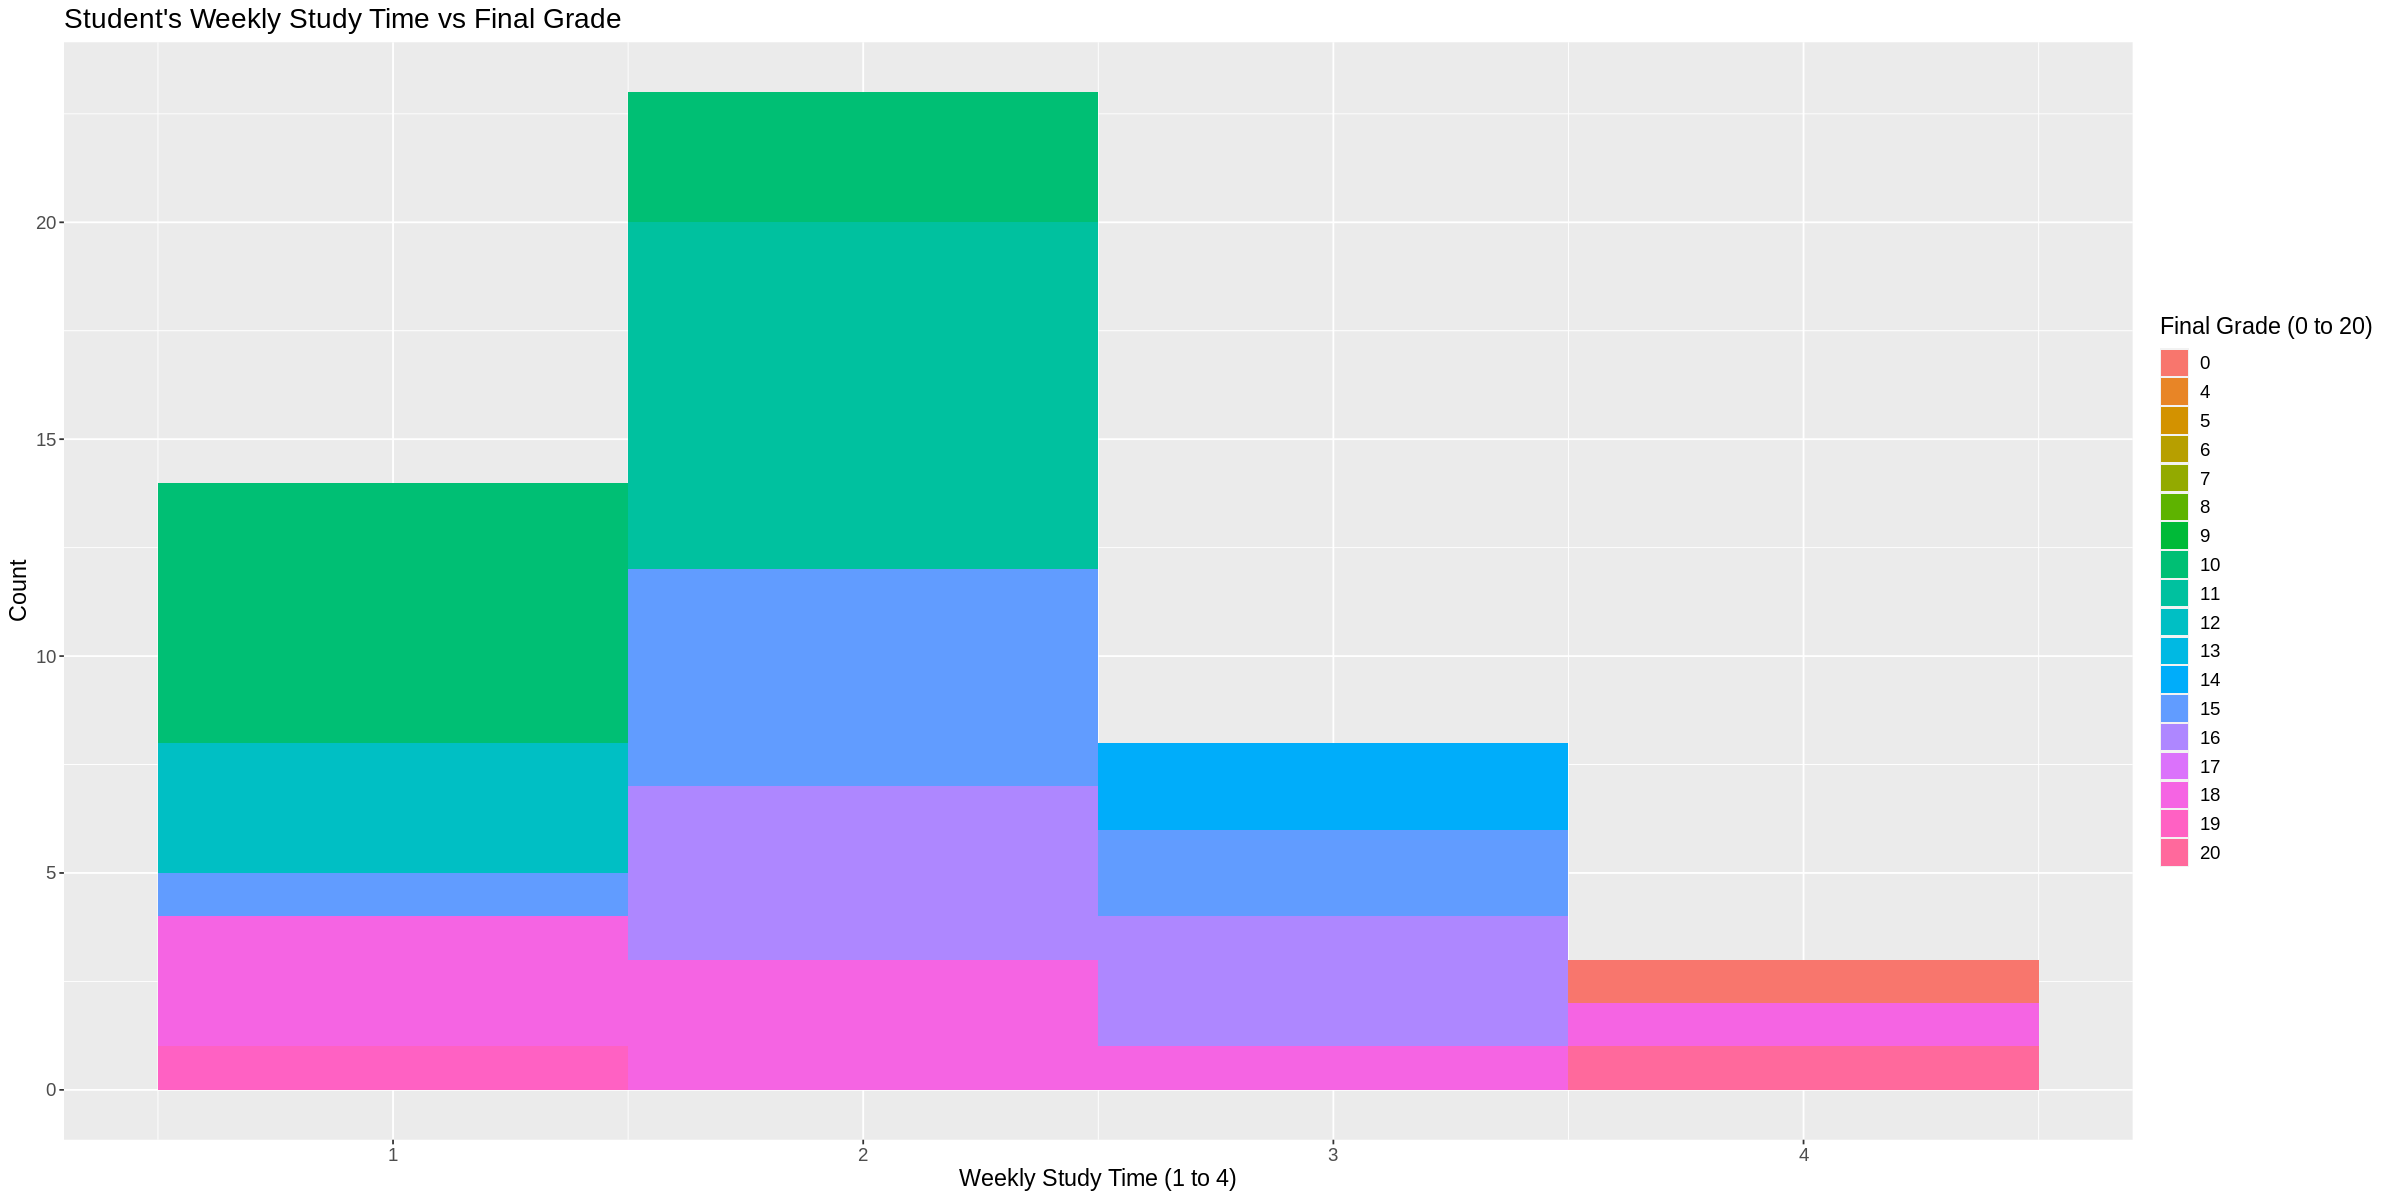

In [58]:
# create a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

studytime_plot <- student_train %>%
    ggplot(aes(x = studytime, fill = as_factor(G3))) +
    geom_histogram(position = "identity", binwidth = 1) +
    labs(x = "Weekly Study Time (1 to 4)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Student's Weekly Study Time vs Final Grade") +
    theme(text = element_text(size = 14))

studytime_plot

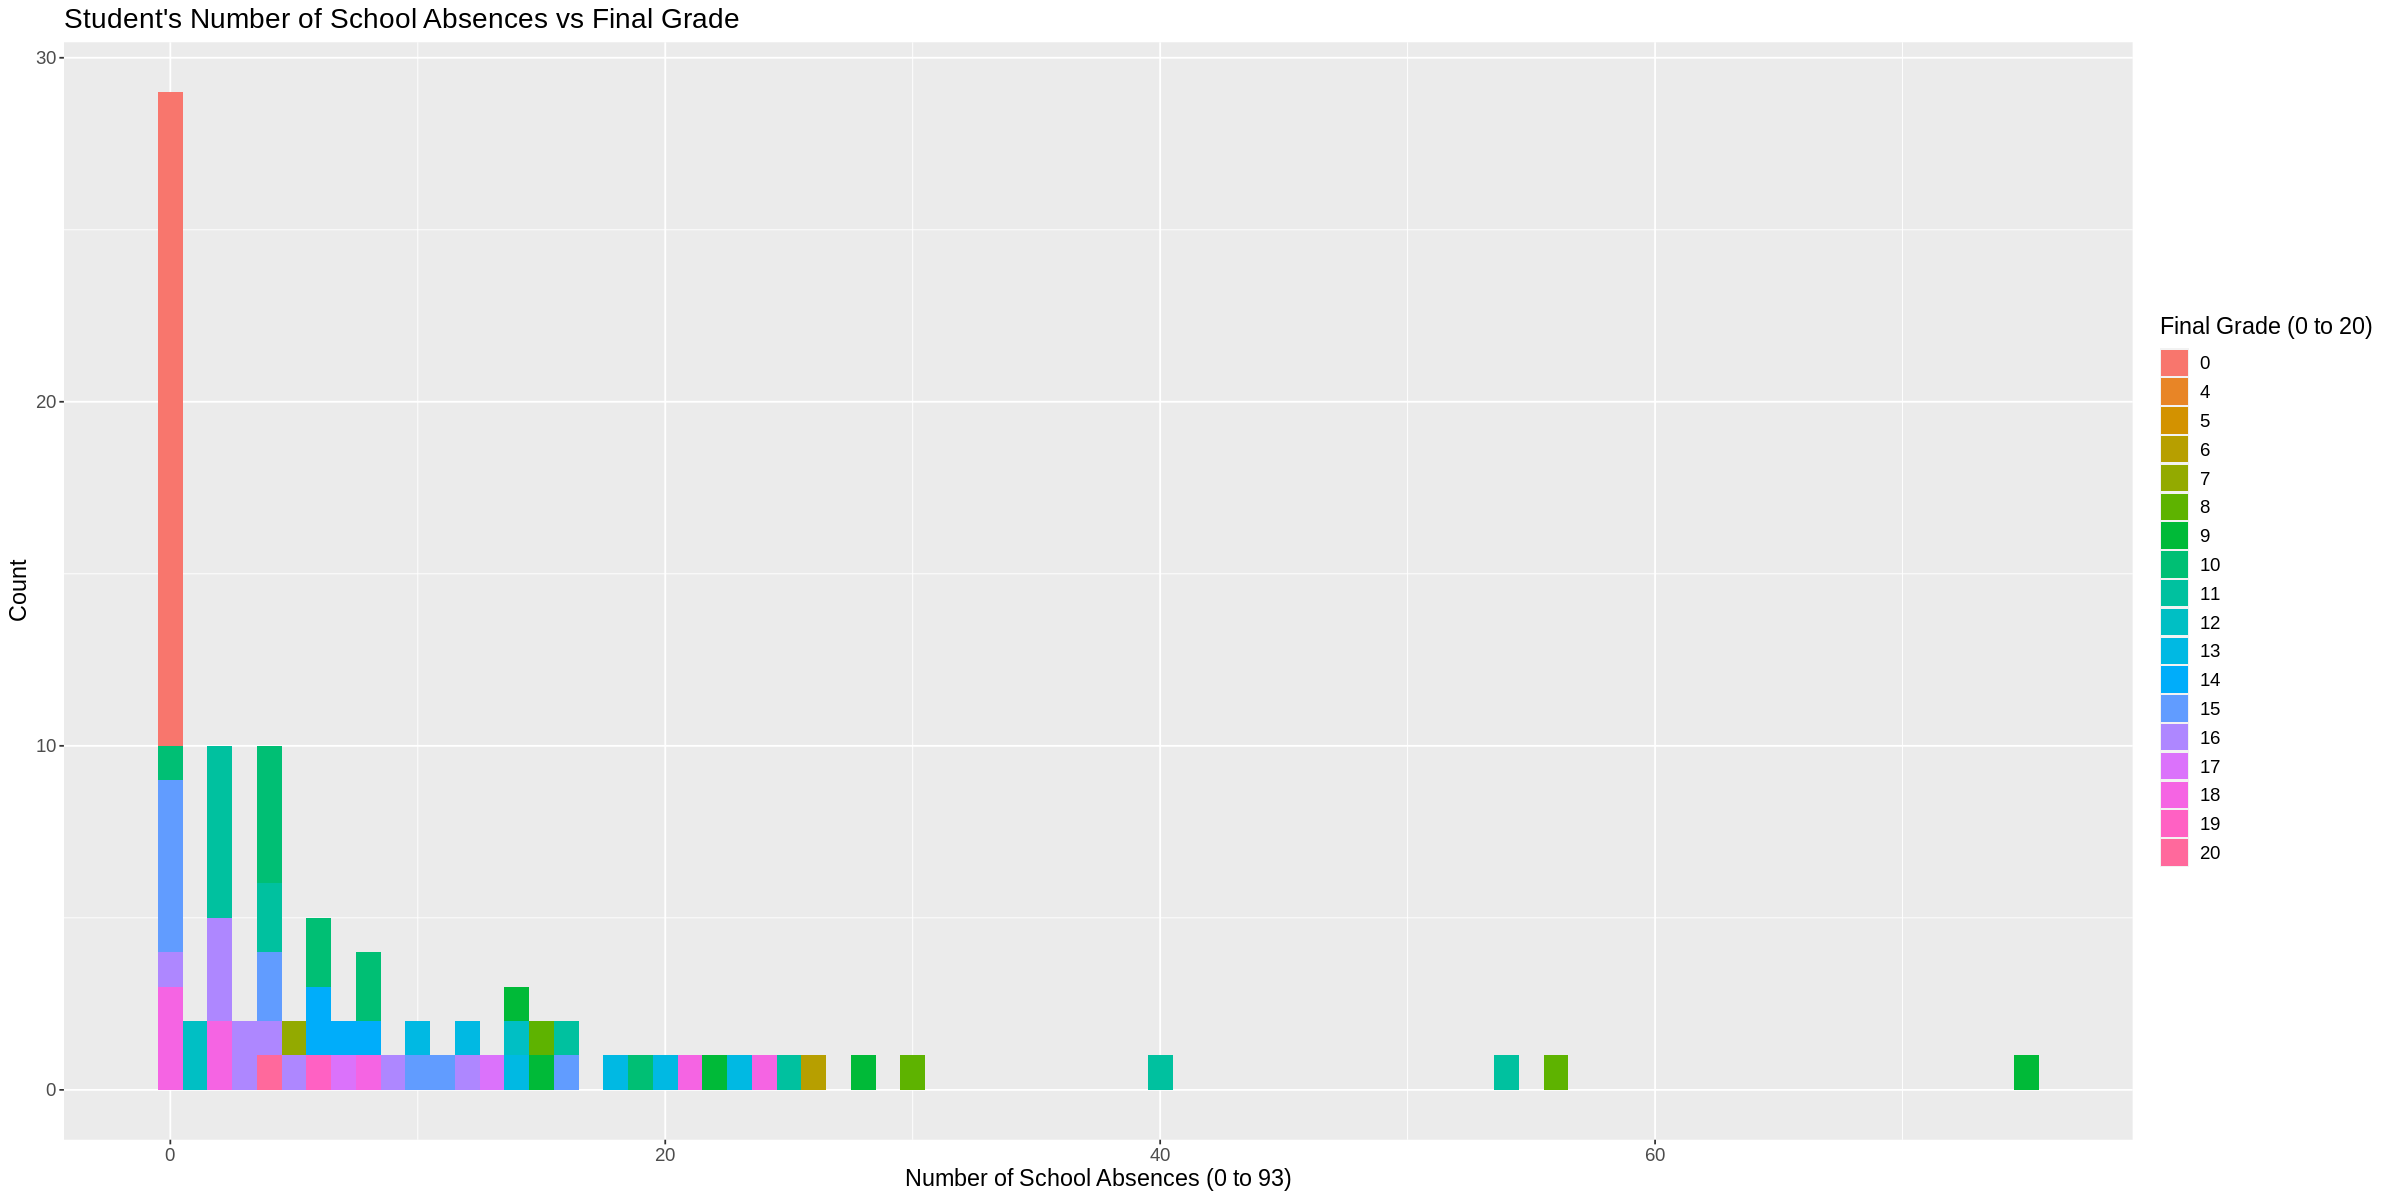

In [59]:
#options(repr.plot.width = 20, repr.plot.height = 10)

absences_plot <- student_train %>%
    ggplot(aes(x = absences, fill = as_factor(G3))) +
    geom_histogram(position = "identity", binwidth = 1) +
    labs(x = "Number of School Absences (0 to 93)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Student's Number of School Absences vs Final Grade") +
    theme(text = element_text(size = 14)) #+
    #coord_flip()

absences_plot

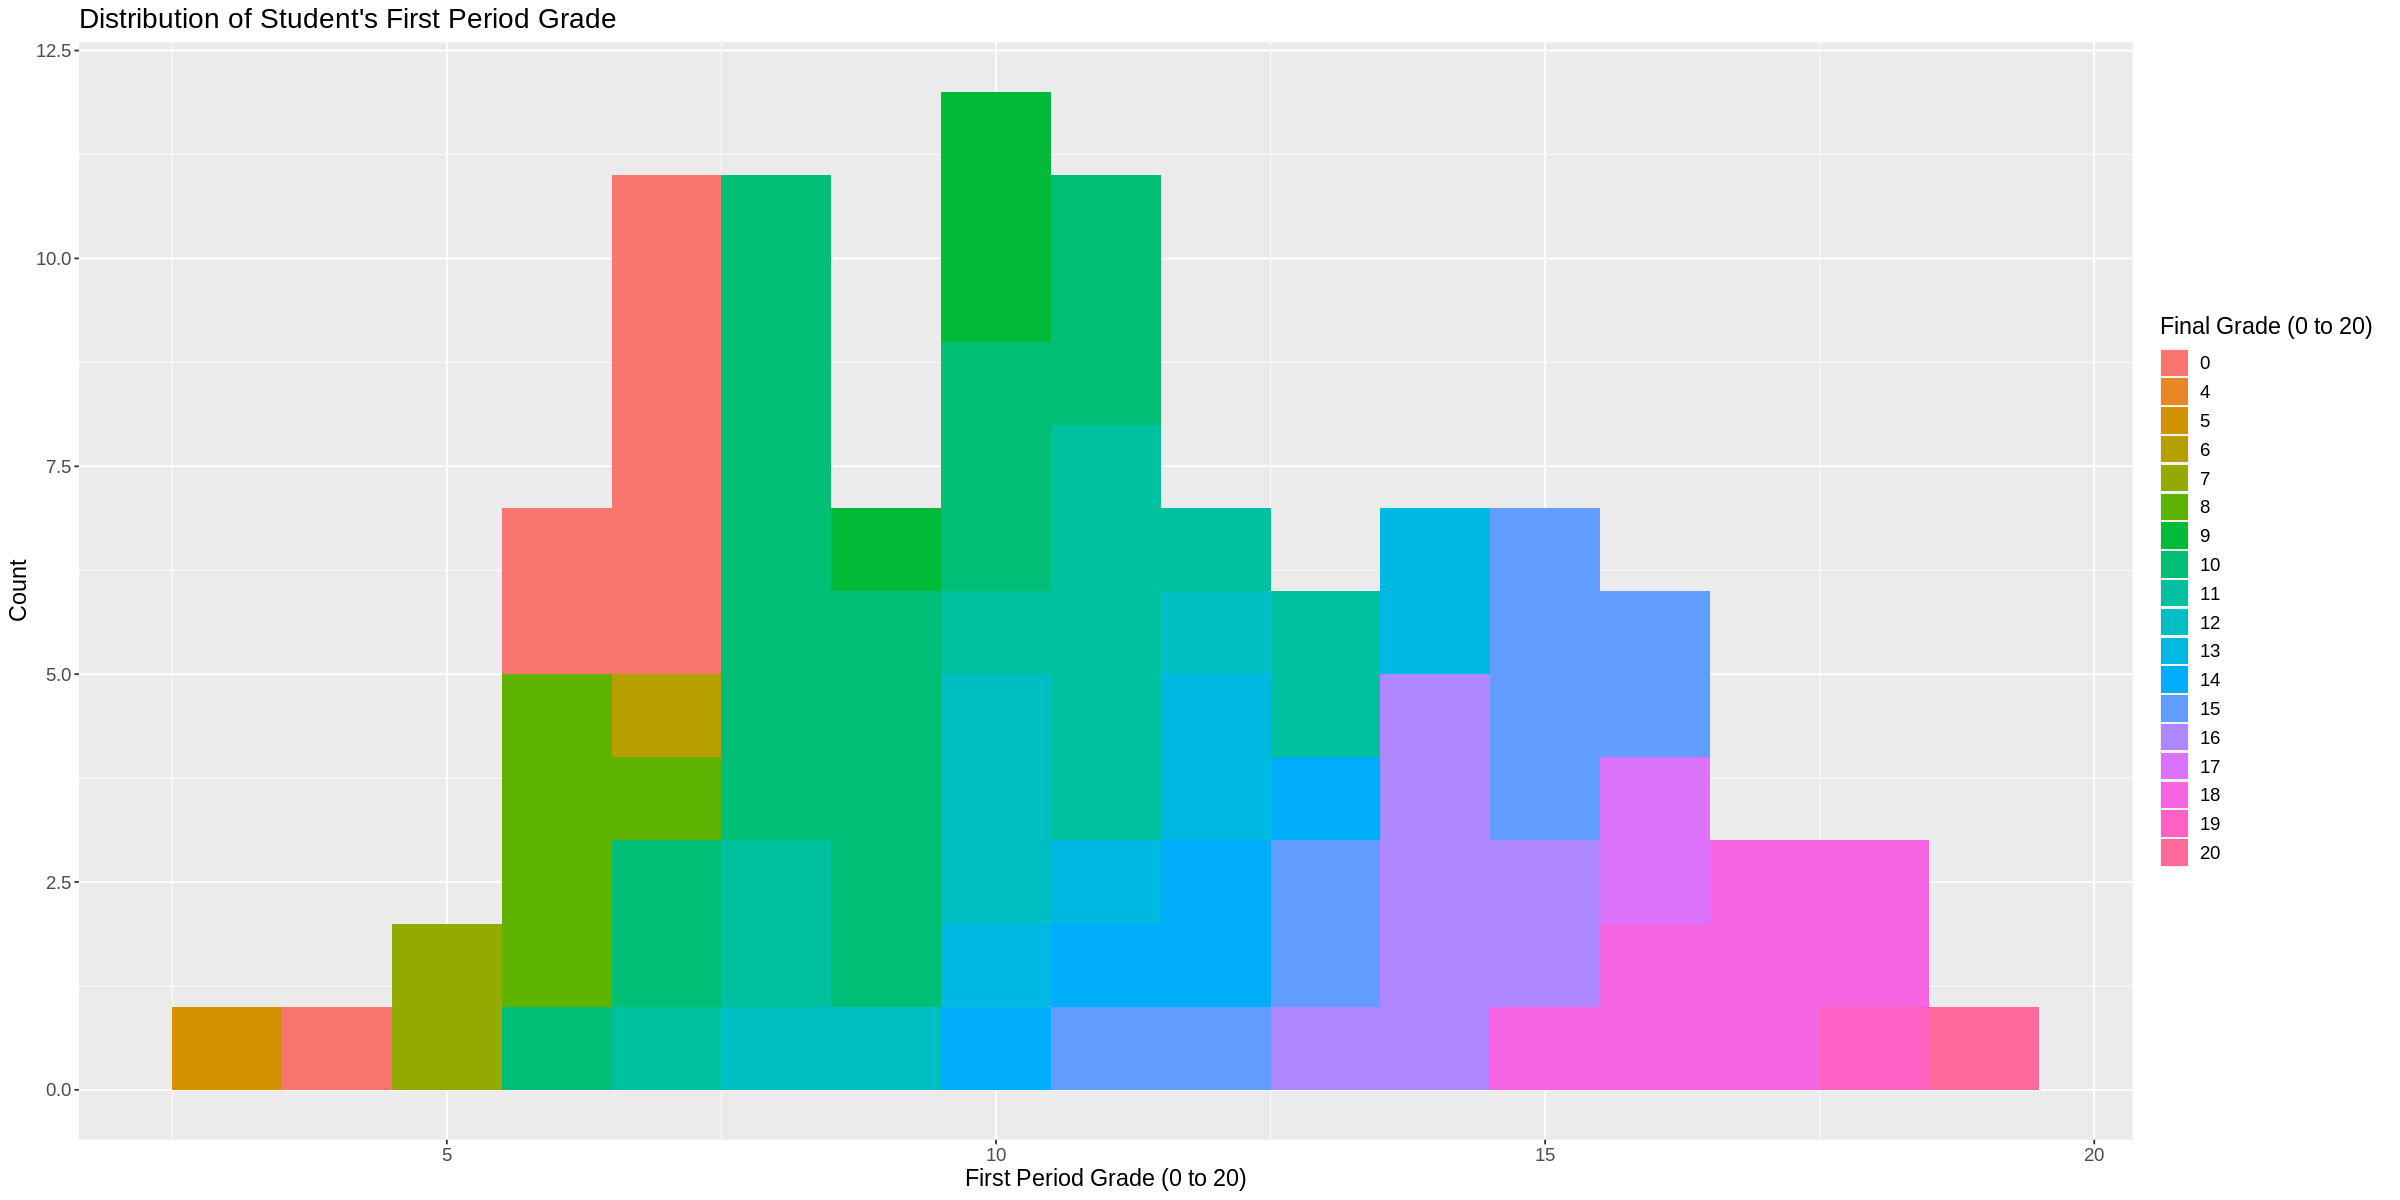

In [56]:
#options(repr.plot.width = 10, repr.plot.height = 10)

G1_plot <- student_train %>%
    ggplot(aes(x = G1, fill = as_factor (G3))) +
    geom_histogram(position = "identity", binwidth = 1) +
    labs(x = "First Period Grade (0 to 20)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Distribution of Student's First Period Grade") +
    theme(text = element_text(size = 14))

G1_plot

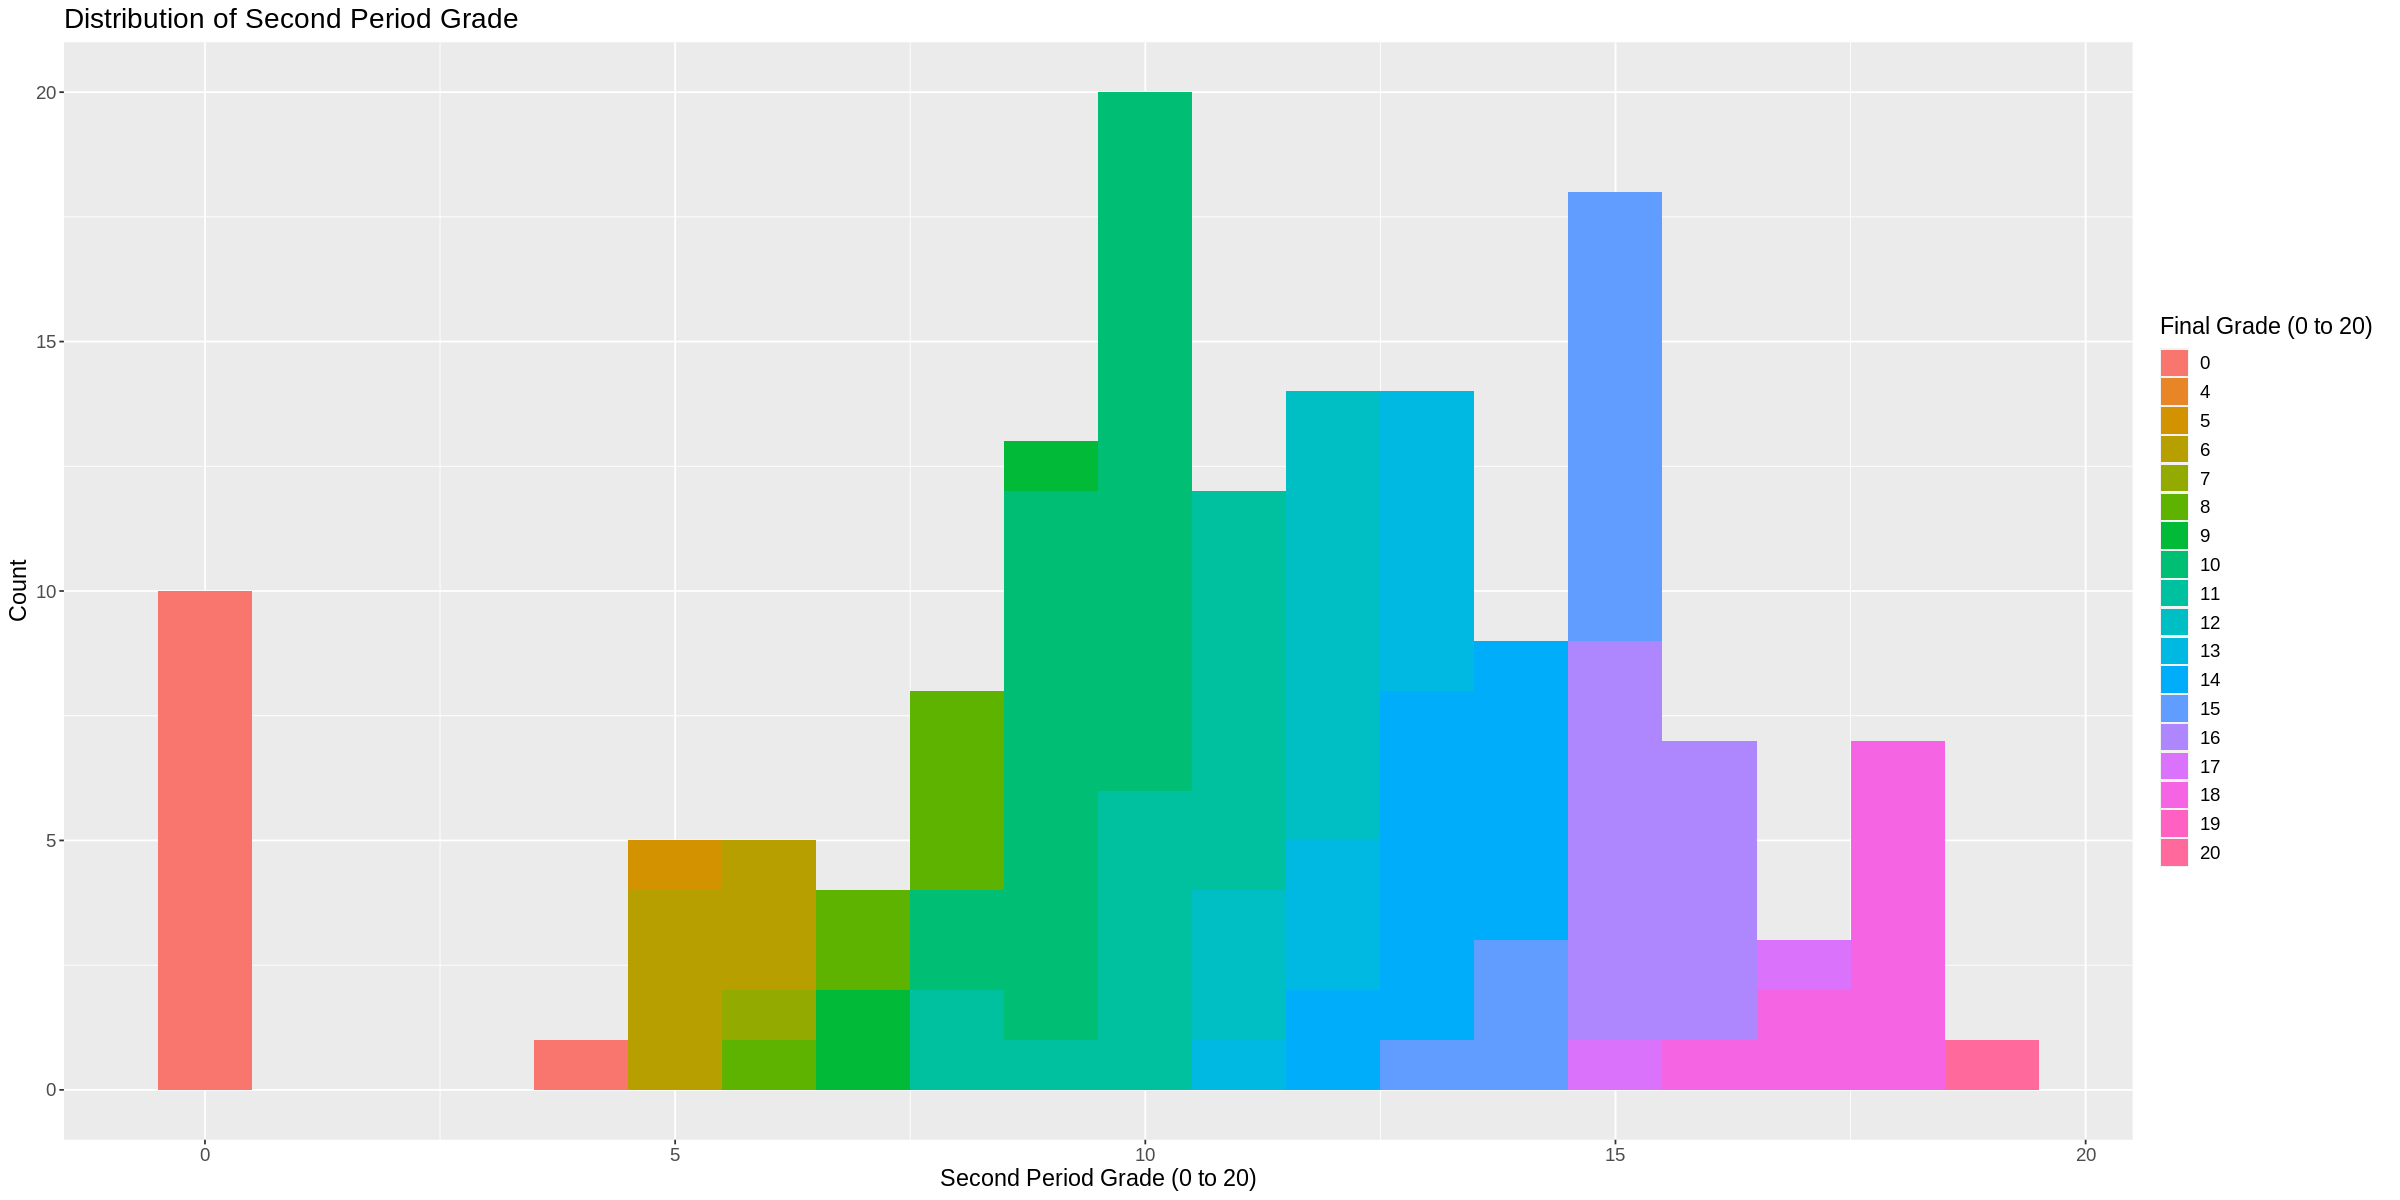

In [57]:
#options(repr.plot.width = 10, repr.plot.height = 10)

G2_plot <- student_train %>%
    ggplot(aes(x = G2, fill = as_factor (G3))) +
    geom_histogram(position = "identity", binwidth = 1) +
    labs(x = "Second Period Grade (0 to 20)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Distribution of Second Period Grade") +
    theme(text = element_text(size = 14))

G2_plot

In [78]:
# perform the data analysis

# create recipe to preprocess data
student_recipe <- recipe(G3 ~ G2, data = student_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# model specification
student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

# 10-fold cross validation object
student_vfold <- vfold_cv(student_train, v = 10, strata = G3)

student_workflow <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(student_spec)

student_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [96]:
# run cross validation for a grid of numbers of neighbors ranging from 1 to 200
gridvals <- tibble(neighbors = seq(1:50))

# tune the model and return the RMSPE for each number of neighbor
student_results <- student_workflow %>%
    tune_grid(resamples = student_vfold, grid = gridvals) %>%
    collect_metrics()

# find the minimum RMSPE
student_min <- student_results %>%
    filter(.metric == "rmse") %>%
    filter(mean == min(mean))
    #arrange(desc (mean, std_error)) %>%
    #slice (200)

student_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,1.972758,10,0.1839289,Model17


In [97]:
# retrain model on training data using K value with smallest RMSE
k_min <- student_min %>%
    pull(neighbors)

student_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("regression")

student_best_fit <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(student_best_spec) %>%
    fit(data = student_train)

#Assess RMSPE of test data predictions
student_summary <- student_best_fit %>%
    predict(student_test) %>%
    bind_cols(student_test) %>%
    metrics(truth = G3, estimate = .pred)

student_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.030921
rsq,standard,0.785620
mae,standard,1.218921


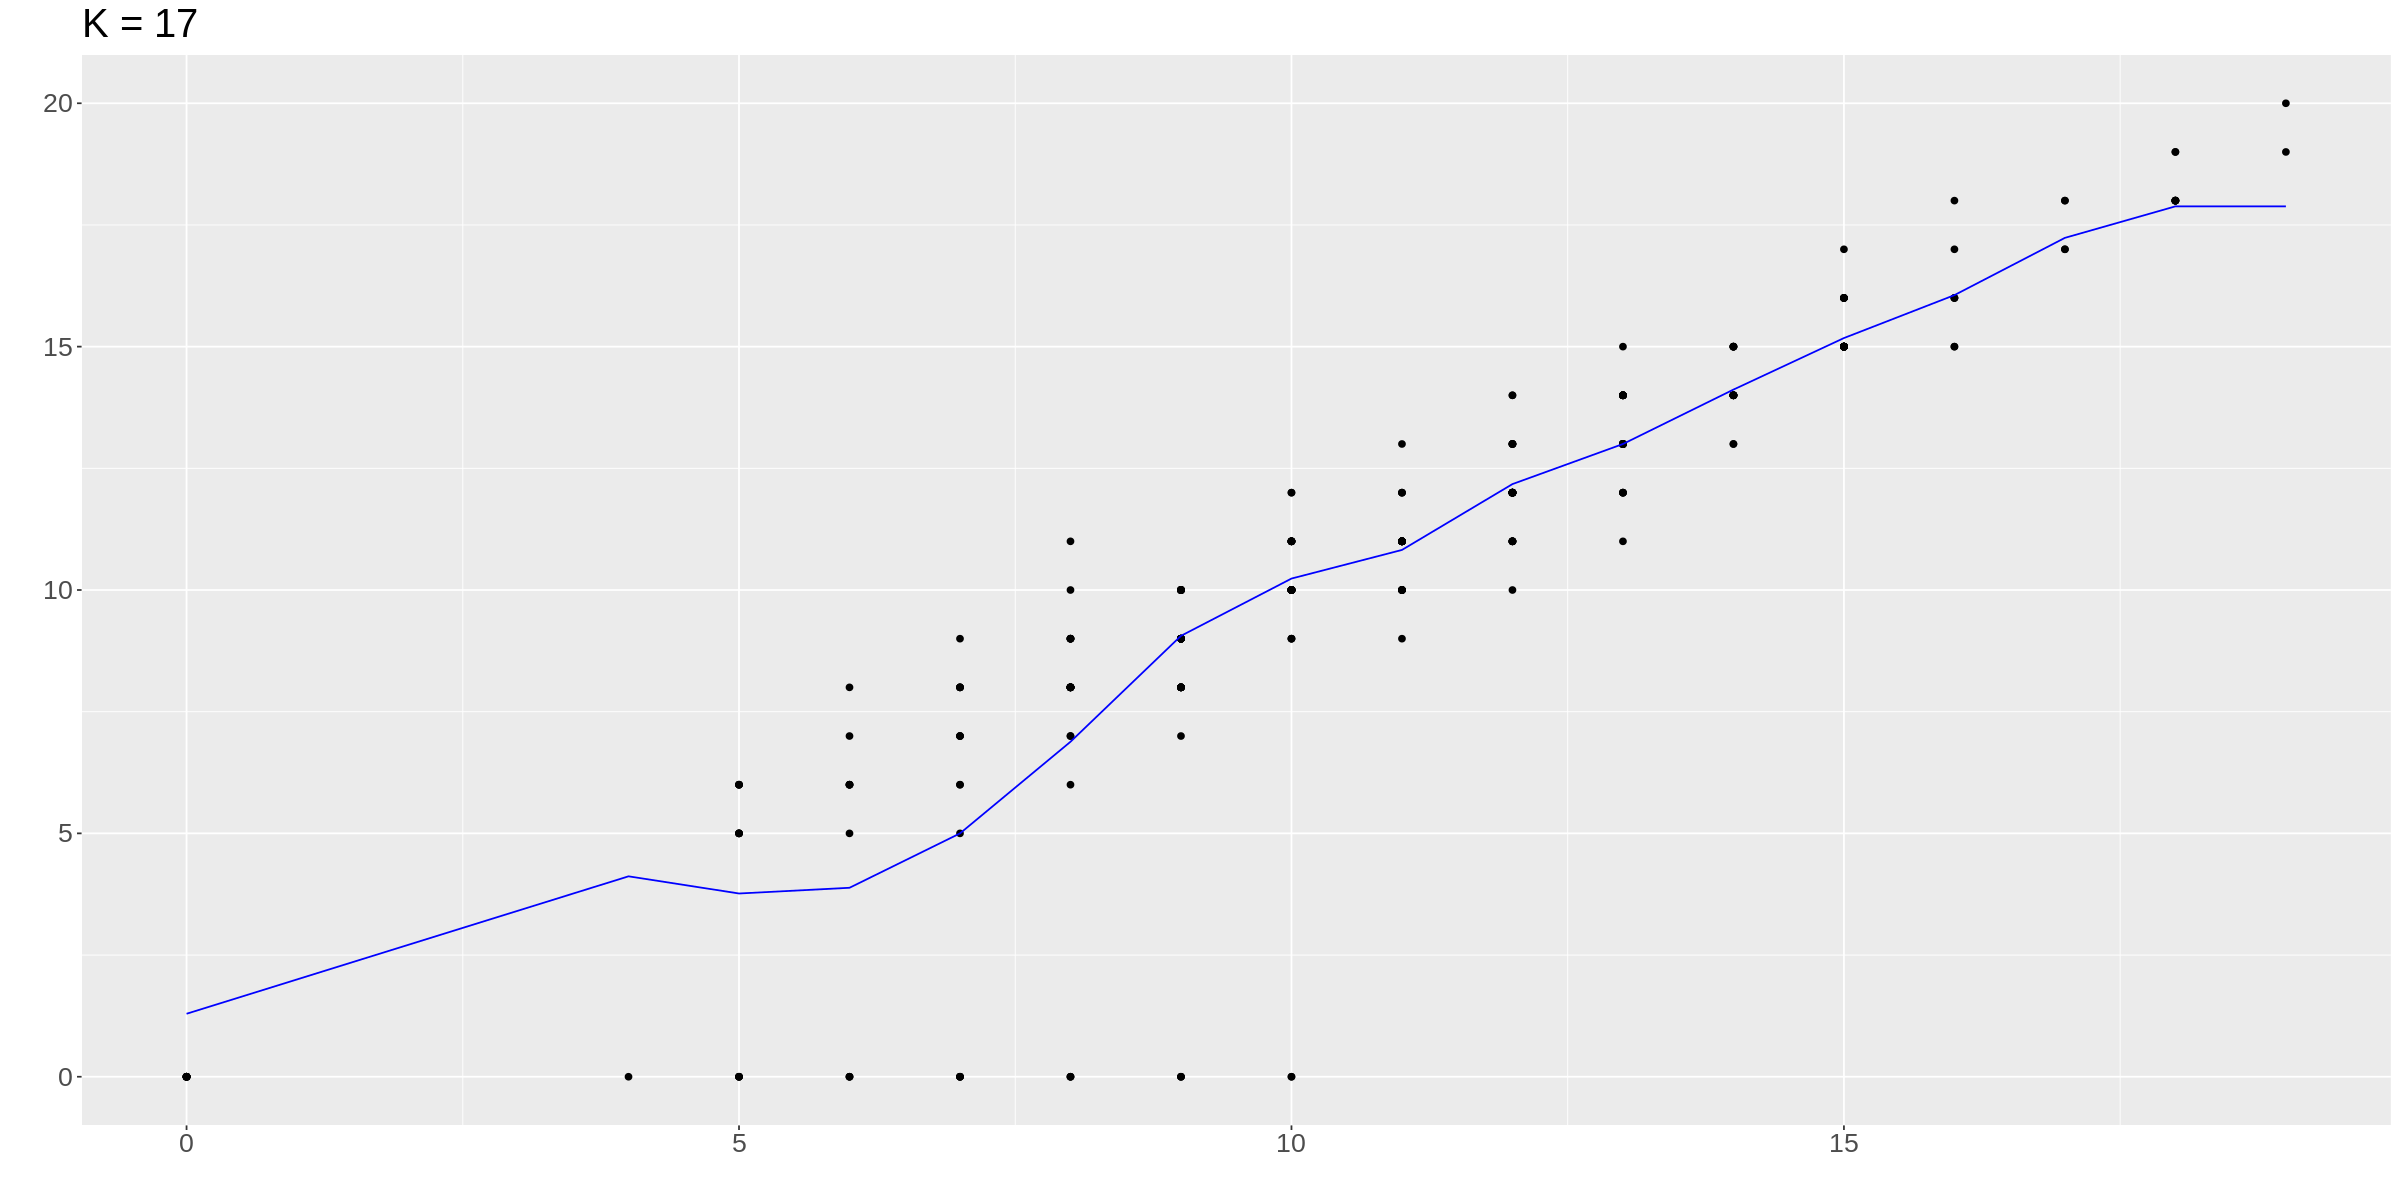

In [98]:
# create a visualization of the analysis 
#Visualize
student_preds <- student_best_fit %>%
    predict(student_train) %>%
    bind_cols(student_train)

student_plot <- ggplot(student_preds, aes(x=G2, y=G3)) +
    geom_point() +
    geom_line(data = student_preds, mapping = aes(x= G2, y= .pred), colour = "blue") +
    labs(x= "", y = "") +
    theme(text= element_text(size=20)) +
    ggtitle(paste0("K = ", k_min))
student_plot

## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.